# JUG Quickstart Guide

This notebook demonstrates how to use JUG (JAX-based pUlsar timinG) for pulsar timing analysis.

We'll cover:
1. Loading pulsar data (par + tim files)
2. Computing and plotting residuals
3. Understanding a well-fit pulsar
4. Fitting a poorly-fit pulsar
5. Comparing before/after results

In [1]:
# Setup: Add JUG to path and import
import sys
from pathlib import Path

# Add parent directory to path (if running from notebooks/)
sys.path.insert(0, str(Path.cwd().parent))

import numpy as np
import matplotlib.pyplot as plt

# JUG imports
from jug.engine.session import TimingSession
from jug.engine.api import open_session

# Set up nice plotting
plt.rcParams['figure.figsize'] = (12, 5)
plt.rcParams['font.size'] = 11

## 1. Loading a Well-Fit Pulsar (J1909-3744)

J1909-3744 is a millisecond pulsar with excellent timing precision. Let's load it and see what good residuals look like.

In [2]:
# Define paths to the data files
data_dir = Path.cwd().parent / "data" / "pulsars"

par_file = data_dir / "J1909-3744_tdb.par"
tim_file = data_dir / "J1909-3744.tim"

print(f"Par file: {par_file}")
print(f"Tim file: {tim_file}")
print(f"Files exist: par={par_file.exists()}, tim={tim_file.exists()}")

Par file: /home/mattm/soft/JUG/data/pulsars/J1909-3744_tdb.par
Tim file: /home/mattm/soft/JUG/data/pulsars/J1909-3744.tim
Files exist: par=True, tim=True


In [3]:
# Create a timing session
# This parses the files and caches expensive computations
session = TimingSession(par_file, tim_file, verbose=True)

Opening session: J1909-3744_tdb.par + J1909-3744.tim
  Loaded 10408 TOAs
  Session ready


In [5]:
# Compute residuals
result = session.compute_residuals(subtract_tzr=True)

print(f"\nResiduals computed for {result['n_toas']} TOAs")
print(f"RMS: {result['rms_us']:.3f} microseconds")
print(f"Mean: {result['mean_us']:.3f} microseconds")

  Using cached residuals (subtract_tzr=True)

Residuals computed for 10408 TOAs
RMS: 0.404 microseconds
Mean: 0.071 microseconds


In [6]:
# Extract data for plotting
tdb_mjd = result['tdb_mjd']        # Time (MJD)
residuals_us = result['residuals_us']  # Residuals in microseconds
errors_us = result['errors_us']    # TOA uncertainties

# Convert MJD to years for nicer x-axis
years = 2000 + (tdb_mjd - 51544.0) / 365.25

### Basic Residuals Plot

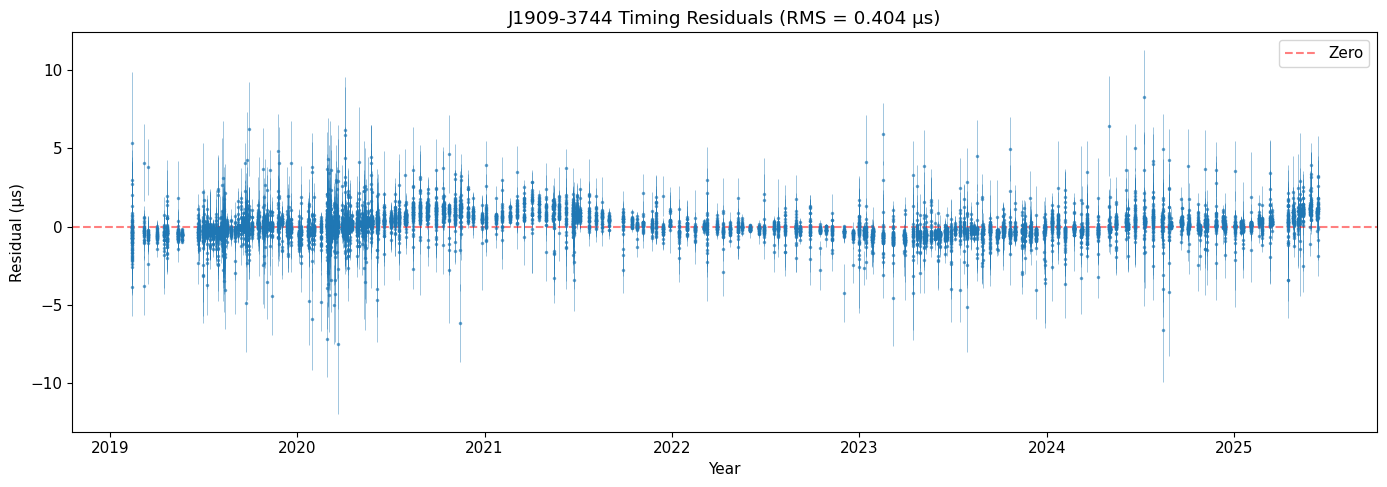

In [7]:
plt.figure(figsize=(14, 5))
plt.errorbar(years, residuals_us, yerr=errors_us, fmt='.', markersize=3, 
             alpha=0.6, capsize=0, elinewidth=0.5)
plt.axhline(y=0, color='r', linestyle='--', alpha=0.5, label='Zero')
plt.xlabel('Year')
plt.ylabel('Residual (μs)')
plt.title(f'J1909-3744 Timing Residuals (RMS = {result["rms_us"]:.3f} μs)')
plt.legend()
plt.tight_layout()
plt.show()

### Residuals with Weighted RMS Bands

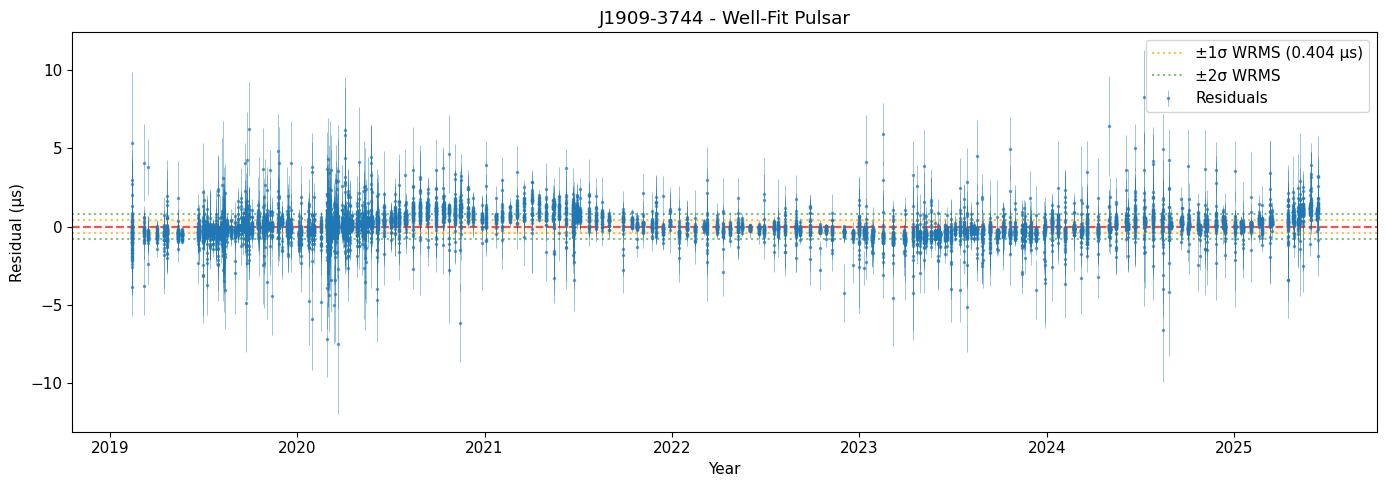

In [8]:
# Compute weighted statistics
weights = 1.0 / errors_us**2
weighted_mean = np.sum(residuals_us * weights) / np.sum(weights)
wrms = np.sqrt(np.sum((residuals_us - weighted_mean)**2 * weights) / np.sum(weights))

plt.figure(figsize=(14, 5))
plt.errorbar(years, residuals_us, yerr=errors_us, fmt='.', markersize=3, 
             alpha=0.6, capsize=0, elinewidth=0.5, label='Residuals')
plt.axhline(y=0, color='r', linestyle='--', alpha=0.7)
plt.axhline(y=wrms, color='orange', linestyle=':', alpha=0.7, label=f'±1σ WRMS ({wrms:.3f} μs)')
plt.axhline(y=-wrms, color='orange', linestyle=':', alpha=0.7)
plt.axhline(y=2*wrms, color='green', linestyle=':', alpha=0.5, label=f'±2σ WRMS')
plt.axhline(y=-2*wrms, color='green', linestyle=':', alpha=0.5)
plt.fill_between(years, -wrms, wrms, alpha=0.1, color='orange')
plt.xlabel('Year')
plt.ylabel('Residual (μs)')
plt.title(f'J1909-3744 - Well-Fit Pulsar')
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

### Histogram of Residuals

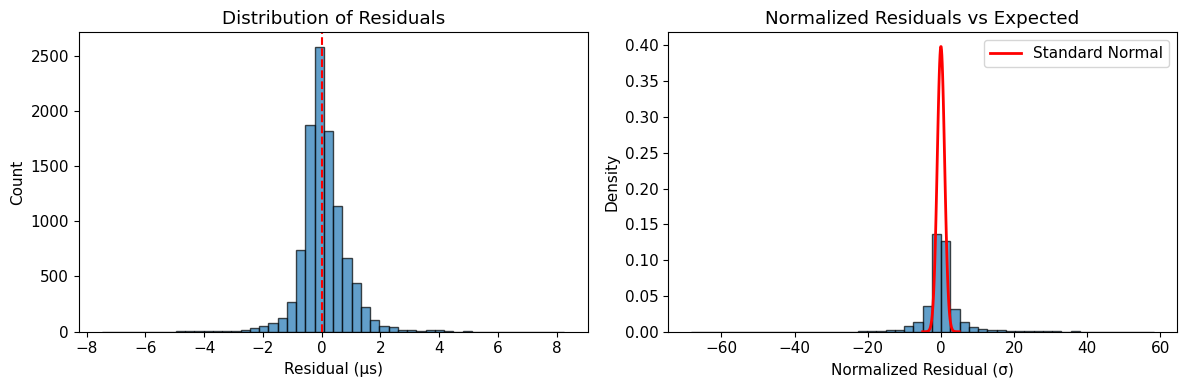

Reduced chi-squared: 32.245
(Should be ~1.0 for a good fit)


In [9]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Histogram of residuals
axes[0].hist(residuals_us, bins=50, edgecolor='black', alpha=0.7)
axes[0].axvline(x=0, color='r', linestyle='--')
axes[0].set_xlabel('Residual (μs)')
axes[0].set_ylabel('Count')
axes[0].set_title('Distribution of Residuals')

# Normalized residuals (residual / error)
normalized = residuals_us / errors_us
axes[1].hist(normalized, bins=50, edgecolor='black', alpha=0.7, density=True)
x = np.linspace(-5, 5, 100)
axes[1].plot(x, np.exp(-x**2/2) / np.sqrt(2*np.pi), 'r-', lw=2, label='Standard Normal')
axes[1].set_xlabel('Normalized Residual (σ)')
axes[1].set_ylabel('Density')
axes[1].set_title('Normalized Residuals vs Expected')
axes[1].legend()

plt.tight_layout()
plt.show()

print(f"Reduced chi-squared: {np.sum(normalized**2) / len(normalized):.3f}")
print(f"(Should be ~1.0 for a good fit)")

### Inspect Timing Model Parameters

In [10]:
# View key parameters from the timing model
params = session.params

print("Key Timing Parameters:")
print("=" * 50)
print(f"Pulsar:      {params.get('PSRJ', 'Unknown')}")
print(f"F0 (Hz):     {params.get('F0', 0):.15f}")
print(f"F1 (Hz/s):   {params.get('F1', 0):.6e}")
print(f"DM (pc/cm³): {params.get('DM', 0):.6f}")
print(f"Binary:      {params.get('BINARY', 'None')}")
if params.get('BINARY'):
    print(f"  PB (days): {params.get('PB', 0):.10f}")
    print(f"  A1 (lt-s): {params.get('A1', 0):.10f}")

Key Timing Parameters:
Pulsar:      J1909-3744
F0 (Hz):     339.315691919040830
F1 (Hz/s):   -1.614750e-15
DM (pc/cm³): 10.390712
Binary:      ELL1
  PB (days): 1.5334494507
  A1 (lt-s): 1.8979908997


---

## 2. Loading a Poorly-Fit Pulsar

Now let's load the same pulsar but with **wrong** parameter values to see what bad residuals look like.

In [11]:
# Load the "wrong" par file
wrong_par_file = data_dir / "J1909-3744_tdb_wrong_F_DM_binary.par"

session_wrong = TimingSession(wrong_par_file, tim_file, verbose=True)

Opening session: J1909-3744_tdb_wrong_F_DM_binary.par + J1909-3744.tim
  Loaded 10408 TOAs
  Session ready


In [12]:
# Compute residuals with wrong parameters
result_wrong = session_wrong.compute_residuals(subtract_tzr=True)

print(f"\nResiduals with WRONG parameters:")
print(f"RMS: {result_wrong['rms_us']:.3f} microseconds")
print(f"\nCompare to correct parameters:")
print(f"RMS: {result['rms_us']:.3f} microseconds")
print(f"\nRatio: {result_wrong['rms_us'] / result['rms_us']:.1f}x worse!")

  Computing residuals...
  Cached TOA data for fast postfit evaluation

Residuals with WRONG parameters:
RMS: 206.828 microseconds

Compare to correct parameters:
RMS: 0.404 microseconds

Ratio: 512.5x worse!


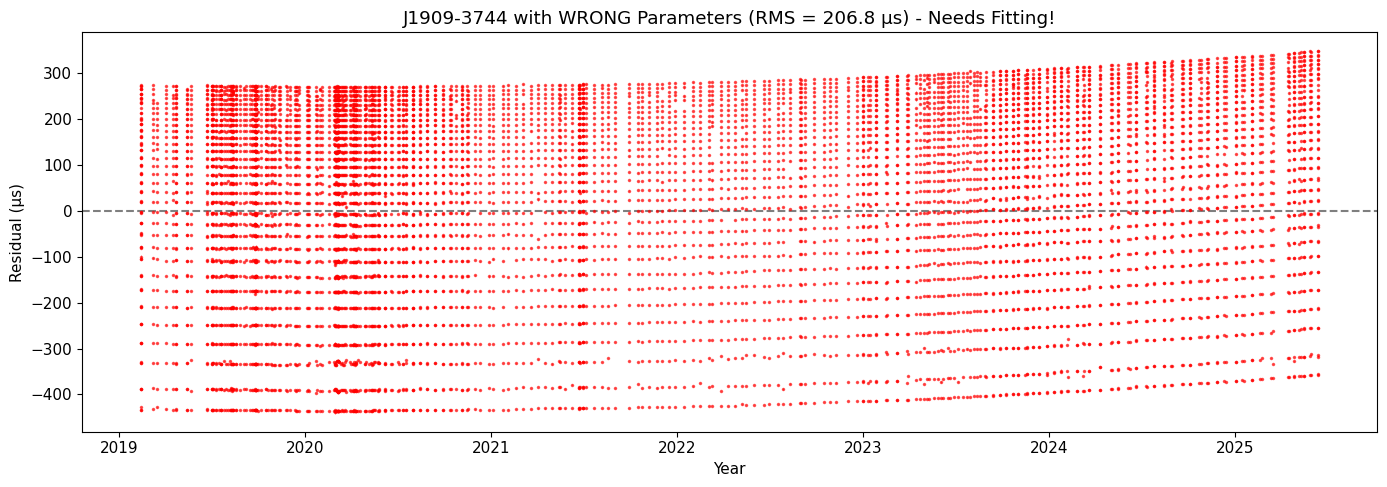

In [13]:
# Plot the wrong residuals
tdb_wrong = result_wrong['tdb_mjd']
res_wrong = result_wrong['residuals_us']
err_wrong = result_wrong['errors_us']
years_wrong = 2000 + (tdb_wrong - 51544.0) / 365.25

plt.figure(figsize=(14, 5))
plt.errorbar(years_wrong, res_wrong, yerr=err_wrong, fmt='.', markersize=3, 
             alpha=0.6, capsize=0, elinewidth=0.5, color='red')
plt.axhline(y=0, color='black', linestyle='--', alpha=0.5)
plt.xlabel('Year')
plt.ylabel('Residual (μs)')
plt.title(f'J1909-3744 with WRONG Parameters (RMS = {result_wrong["rms_us"]:.1f} μs) - Needs Fitting!')
plt.tight_layout()
plt.show()

### Compare Good vs Bad Side-by-Side

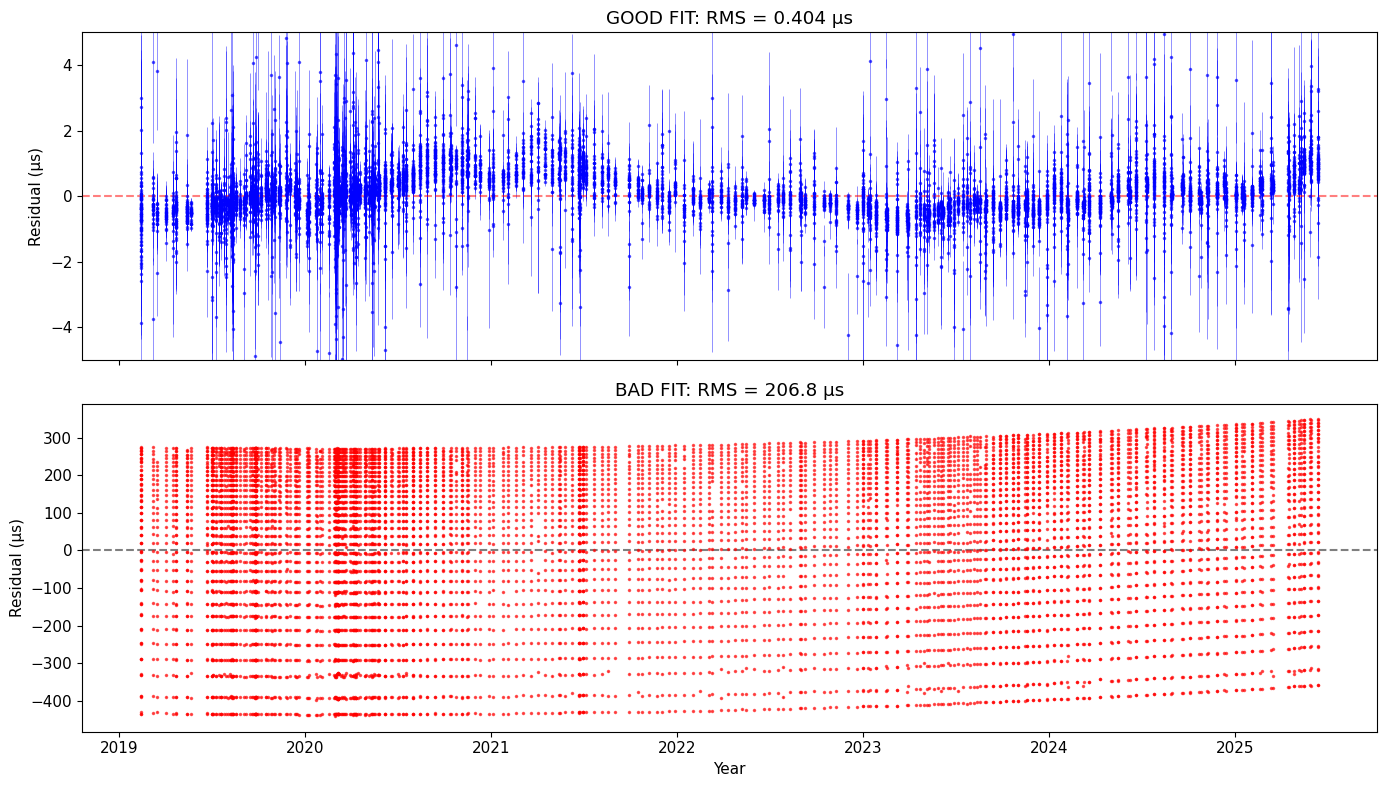

In [14]:
fig, axes = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

# Good fit
axes[0].errorbar(years, residuals_us, yerr=errors_us, fmt='.', markersize=3, 
                 alpha=0.6, capsize=0, elinewidth=0.5, color='blue')
axes[0].axhline(y=0, color='r', linestyle='--', alpha=0.5)
axes[0].set_ylabel('Residual (μs)')
axes[0].set_title(f'GOOD FIT: RMS = {result["rms_us"]:.3f} μs')
axes[0].set_ylim(-5, 5)

# Bad fit
axes[1].errorbar(years_wrong, res_wrong, yerr=err_wrong, fmt='.', markersize=3, 
                 alpha=0.6, capsize=0, elinewidth=0.5, color='red')
axes[1].axhline(y=0, color='black', linestyle='--', alpha=0.5)
axes[1].set_xlabel('Year')
axes[1].set_ylabel('Residual (μs)')
axes[1].set_title(f'BAD FIT: RMS = {result_wrong["rms_us"]:.1f} μs')

plt.tight_layout()
plt.show()

---

## 3. Fitting the Parameters

Now let's use JUG to fit the timing model and fix the residuals!

In [26]:
# Define which parameters to fit
# We'll fit spin, DM, and binary parameters
fit_params = ['F0', 'F1', 'DM', 'DM1','DM2','PB', 'A1', 'SINI']

print(f"Parameters to fit: {fit_params}")
print(f"\nBefore fitting:")
for p in fit_params:
    val = session_wrong.params.get(p, 'N/A')
    if isinstance(val, float):
        if abs(val) < 1e-10 and val != 0:
            print(f"  {p}: {val:.15e}")
        else:
            print(f"  {p}: {val:.15f}")

Parameters to fit: ['F0', 'F1', 'DM', 'DM1', 'DM2', 'PB', 'A1', 'SINI']

Before fitting:
  F0: 339.315691919040830
  F1: -1.614750527970548e-15
  DM: 10.390709920631515
  DM1: -0.000001762152104
  DM2: -0.000052151500503
  PB: 1.533449450721663
  A1: 1.897990897830269
  SINI: 0.997955371866252


In [27]:
# Run the fit!
fit_result = session_wrong.fit_parameters(
    fit_params=fit_params,
    max_iter=25,
    verbose=True  # Show iteration progress
)

  Fitting 8 parameters: F0, F1, DM, DM1, DM2, PB, A1, SINI
  Computing residuals (subtract_tzr=False) for fitting cache...
  Computing residuals...
  Cached TOA data for fast postfit evaluation
  Using cached arrays for fitting (fast path)

Iter   RMS (μs)     ΔParam          λ        Status              
---------------------------------------------------------------------------
1         0.404532   8.443253e-06  1.0                          
2         0.403699   3.417534e-06  1.0                          
3         0.403680   6.957468e-08  0.062                        
4         0.403679   1.744766e-08  0.008                        
5         0.403677   4.352047e-09  0.002                        
         (step rejected at λ=0.0010, converged at minimum)


In [28]:
# Check the fit results
print("\n" + "=" * 60)
print("FIT RESULTS")
print("=" * 60)
print(f"Converged: {fit_result['converged']}")
print(f"Iterations: {fit_result['iterations']}")
print(f"\nRMS before fit: {fit_result['prefit_rms']:.3f} μs")
print(f"RMS after fit:  {fit_result['final_rms']:.3f} μs")
print(f"Improvement:    {fit_result['prefit_rms'] / fit_result['final_rms']:.1f}x better!")


FIT RESULTS
Converged: True
Iterations: 6

RMS before fit: 0.405 μs
RMS after fit:  0.404 μs
Improvement:    1.0x better!


In [29]:
# Show fitted parameter values with uncertainties
print("\nFitted Parameters:")
print("-" * 60)
for p in fit_params:
    val = fit_result['final_params'][p]
    unc = fit_result['uncertainties'][p]
    if abs(val) < 1e-10 and val != 0:
        print(f"  {p:6s} = {val:>22.15e} ± {unc:.3e}")
    else:
        print(f"  {p:6s} = {val:>22.15f} ± {unc:.3e}")


Fitted Parameters:
------------------------------------------------------------
  F0     =    339.315691919040830 ± 3.187e-14
  F1     = -1.614750138466404e-15 ± 5.183e-22
  DM     =     10.390711886872575 ± 8.689e-07
  DM1    =     -0.000001764785351 ± 2.718e-09
  DM2    =     -0.000052151495214 ± 3.683e-12
  PB     =      1.533449450723379 ± 3.776e-14
  A1     =      1.897990898341628 ± 1.013e-09
  SINI   =      0.997960488959352 ± 5.309e-06


### Plot Fitted Residuals

In [30]:
# Compute residuals with the new fitted parameters
result_fitted = session_wrong.compute_residuals(subtract_tzr=True, force_recompute=True)

tdb_fitted = result_fitted['tdb_mjd']
res_fitted = result_fitted['residuals_us']
err_fitted = result_fitted['errors_us']
years_fitted = 2000 + (tdb_fitted - 51544.0) / 365.25

print(f"Post-fit RMS: {result_fitted['rms_us']:.3f} μs")

  Computing residuals...
  Cached TOA data for fast postfit evaluation
Post-fit RMS: 0.404 μs


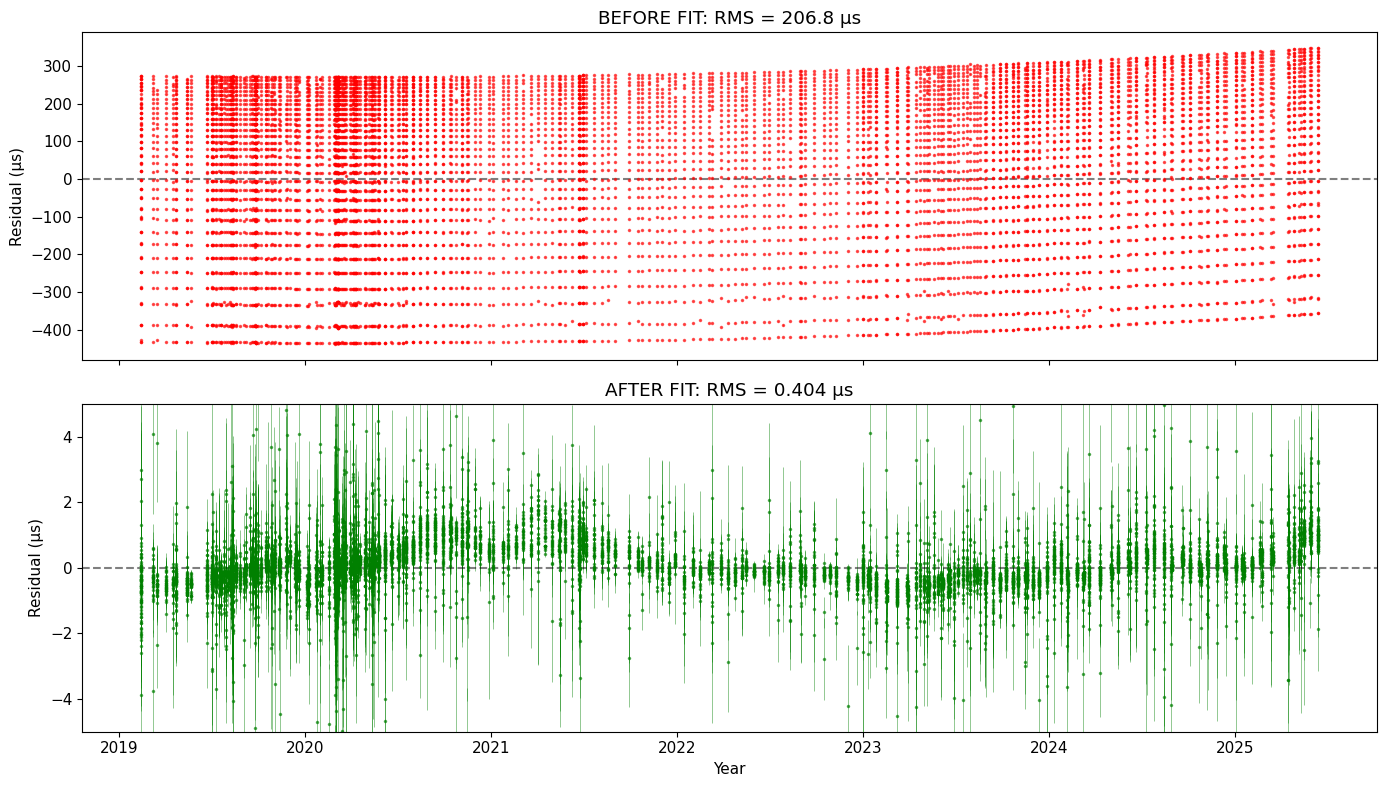

In [31]:
# Compare before and after fitting
fig, axes = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

# Before fitting
axes[0].errorbar(years_wrong, res_wrong, yerr=err_wrong, fmt='.', markersize=3, 
                 alpha=0.6, capsize=0, elinewidth=0.5, color='red')
axes[0].axhline(y=0, color='black', linestyle='--', alpha=0.5)
axes[0].set_ylabel('Residual (μs)')
axes[0].set_title(f'BEFORE FIT: RMS = {result_wrong["rms_us"]:.1f} μs')

# After fitting
axes[1].errorbar(years_fitted, res_fitted, yerr=err_fitted, fmt='.', markersize=3, 
                 alpha=0.6, capsize=0, elinewidth=0.5, color='green')
axes[1].axhline(y=0, color='black', linestyle='--', alpha=0.5)
axes[1].set_xlabel('Year')
axes[1].set_ylabel('Residual (μs)')
axes[1].set_title(f'AFTER FIT: RMS = {result_fitted["rms_us"]:.3f} μs')
axes[1].set_ylim(-5, 5)

plt.tight_layout()
plt.show()

### Final Comparison: Original Good Fit vs Our Fitted Result

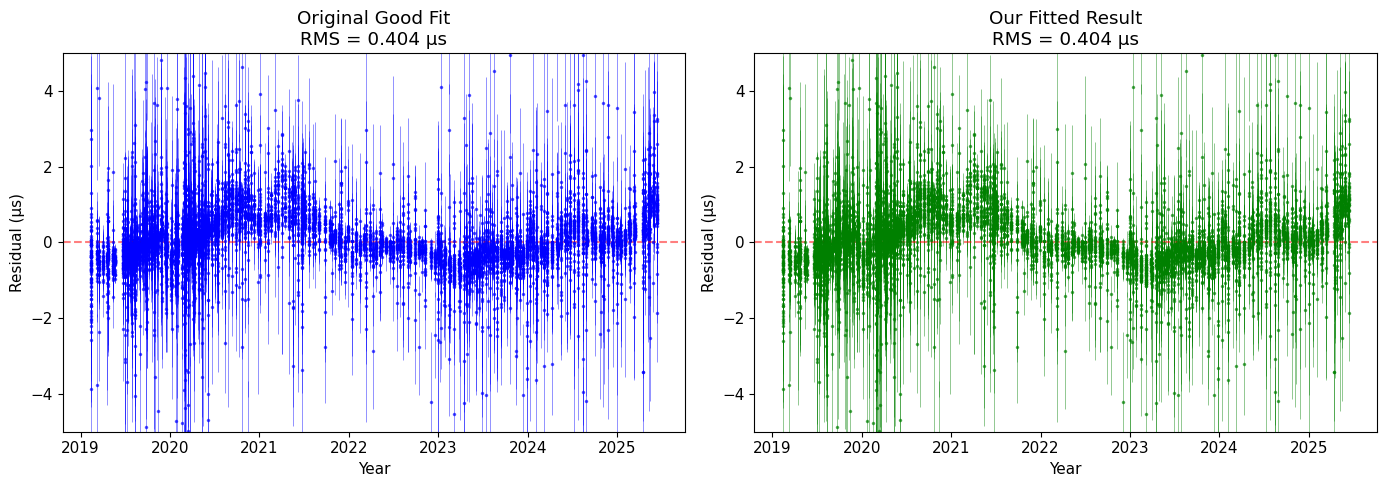


Our fit recovered the timing solution!
Original RMS:   0.4035 μs
Our fitted RMS: 0.4035 μs
Difference:     0.0000 μs


In [32]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Original good fit
axes[0].errorbar(years, residuals_us, yerr=errors_us, fmt='.', markersize=3, 
                 alpha=0.6, capsize=0, elinewidth=0.5, color='blue')
axes[0].axhline(y=0, color='r', linestyle='--', alpha=0.5)
axes[0].set_xlabel('Year')
axes[0].set_ylabel('Residual (μs)')
axes[0].set_title(f'Original Good Fit\nRMS = {result["rms_us"]:.3f} μs')
axes[0].set_ylim(-5, 5)

# Our fitted result
axes[1].errorbar(years_fitted, res_fitted, yerr=err_fitted, fmt='.', markersize=3, 
                 alpha=0.6, capsize=0, elinewidth=0.5, color='green')
axes[1].axhline(y=0, color='r', linestyle='--', alpha=0.5)
axes[1].set_xlabel('Year')
axes[1].set_ylabel('Residual (μs)')
axes[1].set_title(f'Our Fitted Result\nRMS = {result_fitted["rms_us"]:.3f} μs')
axes[1].set_ylim(-5, 5)

plt.tight_layout()
plt.show()

print(f"\nOur fit recovered the timing solution!")
print(f"Original RMS:   {result['rms_us']:.4f} μs")
print(f"Our fitted RMS: {result_fitted['rms_us']:.4f} μs")
print(f"Difference:     {abs(result['rms_us'] - result_fitted['rms_us']):.4f} μs")

---

## 4. Additional Options

### Fitting Specific Subsets of TOAs

In [33]:
# You can fit using only a subset of TOAs using a boolean mask
n_toas = session.get_toa_count()

# Example: fit using only the first half of the data
mask = np.zeros(n_toas, dtype=bool)
mask[:n_toas//2] = True

print(f"Total TOAs: {n_toas}")
print(f"Using {mask.sum()} TOAs for fitting (first half)")

Total TOAs: 10408
Using 5204 TOAs for fitting (first half)


In [34]:
dir(fit_result)

['__class__',
 '__class_getitem__',
 '__contains__',
 '__delattr__',
 '__delitem__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__ior__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__ne__',
 '__new__',
 '__or__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__reversed__',
 '__ror__',
 '__setattr__',
 '__setitem__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 'clear',
 'copy',
 'fromkeys',
 'get',
 'items',
 'keys',
 'pop',
 'popitem',
 'setdefault',
 'update',
 'values']

### Accessing the Covariance Matrix

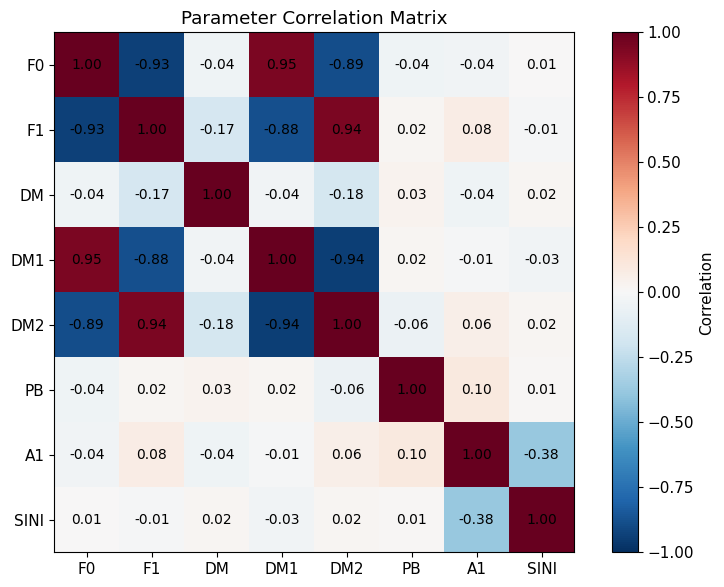

In [35]:
# The fit result includes the parameter covariance matrix
cov = fit_result['covariance']

# Compute correlation matrix
std = np.sqrt(np.diag(cov))
corr = cov / np.outer(std, std)

# Plot correlation matrix
plt.figure(figsize=(8, 6))
im = plt.imshow(corr, cmap='RdBu_r', vmin=-1, vmax=1)
plt.colorbar(im, label='Correlation')
plt.xticks(range(len(fit_params)), fit_params)
plt.yticks(range(len(fit_params)), fit_params)
plt.title('Parameter Correlation Matrix')

# Add correlation values
for i in range(len(fit_params)):
    for j in range(len(fit_params)):
        plt.text(j, i, f'{corr[i,j]:.2f}', ha='center', va='center', fontsize=10)

plt.tight_layout()
plt.show()

### Solver Modes: Exact vs Fast

In [36]:
# JUG supports two solver modes:
# - "exact": SVD-based, bit-for-bit reproducible (default)
# - "fast": QR-based, slightly faster but may have tiny numerical differences

# Reload session to demonstrate
session_demo = TimingSession(wrong_par_file, tim_file, verbose=False)

# Fit with fast solver
fit_fast = session_demo.fit_parameters(
    fit_params=['F0', 'F1'],
    max_iter=10,
    verbose=False,
    solver_mode="fast"  # Use fast QR-based solver
)

print(f"Fast solver RMS: {fit_fast['final_rms']:.6f} μs")
print(f"Iterations: {fit_fast['iterations']}")

Fast solver RMS: 206.624871 μs
Iterations: 4


---

## Summary

In this notebook we learned how to:

1. **Load pulsar data** using `TimingSession(par_file, tim_file)`
2. **Compute residuals** using `session.compute_residuals()`
3. **Plot residuals** using matplotlib
4. **Fit parameters** using `session.fit_parameters(fit_params=[...])`
5. **Access fit results** including uncertainties and covariance matrix

### Key Classes and Functions

| Function | Description |
|----------|-------------|
| `TimingSession(par, tim)` | Create a timing session |
| `session.compute_residuals()` | Compute timing residuals |
| `session.fit_parameters(params)` | Fit specified parameters |
| `session.params` | Access current parameter values |
| `session.get_toa_count()` | Get number of TOAs |